# DonorsChoose

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

!pip install chart_studio
from chart_studio.plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

Output hidden; open in https://colab.research.google.com to view.

## 1.1 Reading Data

In [0]:
project_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_data.csv')
resource_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/resources.csv')

In [4]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [5]:
# how to replace elements in list python: https://stackoverflow.com/a/2582163/4084039
cols = ['Date' if x=='project_submitted_datetime' else x for x in list(project_data.columns)]


#sort dataframe based on time pandas python: https://stackoverflow.com/a/49702492/4084039
project_data['Date'] = pd.to_datetime(project_data['project_submitted_datetime'])
project_data.drop('project_submitted_datetime', axis=1, inplace=True)
project_data.sort_values(by=['Date'], inplace=True)


# how to reorder columns pandas python: https://stackoverflow.com/a/13148611/4084039
project_data = project_data[cols]


project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
55660,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Math & Science,"Applied Sciences, Health & Life Science",Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1
76127,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Special Needs,Special Needs,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1


In [6]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [7]:
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
print(price_data.shape)
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

(260115, 3)


## 1.2 preprocessing of `project_subject_categories`

In [0]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


## 1.3 preprocessing of `project_subject_subcategories`

In [0]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

In [0]:
project_data=project_data.dropna(subset=['teacher_prefix'])

## 1.3 Text preprocessing

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [12]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_categories,clean_subcategories,essay
0,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,Engineering STEAM into the Primary Classroom,I have been fortunate enough to use the Fairy ...,My students come from a variety of backgrounds...,Each month I try to do several science or STEM...,It is challenging to develop high quality scie...,My students need STEM kits to learn critical s...,53,1,725.05,4,Math_Science,AppliedSciences Health_LifeScience,I have been fortunate enough to use the Fairy ...
1,37728,p043609,3f60494c61921b3b43ab61bdde2904df,Ms.,UT,2016-04-27 00:31:25,Grades 3-5,Sensory Tools for Focus,Imagine being 8-9 years old. You're in your th...,"Most of my students have autism, anxiety, anot...",It is tough to do more than one thing at a tim...,When my students are able to calm themselves d...,My students need Boogie Boards for quiet senso...,4,1,213.03,8,SpecialNeeds,SpecialNeeds,Imagine being 8-9 years old. You're in your th...


In [13]:
# printing some random reviews
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)

I have been fortunate enough to use the Fairy Tale STEM kits in my classroom as well as the STEM journals, which my students really enjoyed.  I would love to implement more of the Lakeshore STEM kits in my classroom for the next school year as they provide excellent and engaging STEM lessons.My students come from a variety of backgrounds, including language and socioeconomic status.  Many of them don't have a lot of experience in science and engineering and these kits give me the materials to provide these exciting opportunities for my students.Each month I try to do several science or STEM/STEAM projects.  I would use the kits and robot to help guide my science instruction in engaging and meaningful ways.  I can adapt the kits to my current language arts pacing guide where we already teach some of the material in the kits like tall tales (Paul Bunyan) or Johnny Appleseed.  The following units will be taught in the next school year where I will implement these kits: magnets, motion, si

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [16]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109245/109245 [00:57<00:00, 1894.60it/s]


In [0]:
# after preprocesing
project_data['clean_essay']=preprocessed_essays
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)
project_data.drop(['essay'], axis=1, inplace=True)


<h2><font color='black'> 1.4 Preprocessing of `project_title`</font></h2>

In [18]:
# similarly you can preprocess the titles also

preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())

100%|██████████| 109245/109245 [00:02<00:00, 43806.81it/s]


In [0]:
project_data['clean_title']=preprocessed_titles
project_data.drop(['project_title'], axis=1, inplace=True)


## 1.5 Preparing data for models

In [20]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'clean_categories', 'clean_subcategories',
       'clean_essay', 'clean_title'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

In [21]:
project_data.head(1)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity,clean_categories,clean_subcategories,clean_essay,clean_title
0,8393,p205479,2bf07ba08945e5d8b2a3f269b2b3cfe5,Mrs.,CA,2016-04-27 00:27:36,Grades PreK-2,My students need STEM kits to learn critical s...,53,1,725.05,4,Math_Science,AppliedSciences Health_LifeScience,fortunate enough use fairy tale stem kits clas...,engineering steam primary classroom


In [22]:
"""a=project_data[project_data['project_is_approved']==1]
a=a.sample(n=16000)

b=project_data[project_data['project_is_approved']==0]
b=b.sample(n=16000) 

temp=pd.concat([a,b])

temp = temp.sample(frac=1).reset_index(drop=True)

print(temp.shape)
print(temp['project_is_approved'].value_counts())"""

"a=project_data[project_data['project_is_approved']==1]\na=a.sample(n=16000)\n\nb=project_data[project_data['project_is_approved']==0]\nb=b.sample(n=16000) \n\ntemp=pd.concat([a,b])\n\ntemp = temp.sample(frac=1).reset_index(drop=True)\n\nprint(temp.shape)\nprint(temp['project_is_approved'].value_counts())"

In [23]:
project_data=project_data.sample(frac=0.5)
project_data['project_is_approved'].value_counts()

1    46383
0     8239
Name: project_is_approved, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

y = project_data['project_is_approved'].values
project_data.drop(['project_is_approved'], axis=1, inplace=True)
X = project_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [25]:
print(X_train.shape)
print(X_cv.shape)
print(X_test.shape)

(34957, 15)
(8740, 15)
(10925, 15)


In [26]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(sampling_strategy='minority',random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
print('Resampled dataset shape {0}'.format(Counter(y_train)))

X_train = pd.DataFrame(X_train,columns = X.columns)
X_train.head(5)

Resampled dataset shape Counter({1: 29684, 0: 29684})


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,Date,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,price,quantity,clean_categories,clean_subcategories,clean_essay,clean_title
0,115531,p076562,0d5605ab86fea3eb7c1d33a56148c42b,Mrs.,ME,2016-09-05 10:17:35,Grades 6-8,My students need to keep track of their fitnes...,2,279.93,2,Health_Sports,Gym_Fitness,students love pe physically active unfortunate...,fitness trackers
1,82134,p073922,0fef1b064b1dbf52432a6385a3f1fc9a,Ms.,NC,2017-04-07 21:42:31,Grades PreK-2,My students need these stools for seating at o...,57,108.51,3,Literacy_Language SpecialNeeds,Literature_Writing SpecialNeeds,second grade teacher wonderful group students ...,small group seating other resources ela title 1
2,85836,p091324,e691a3cfff877608f81332d9745c7de4,Mrs.,TN,2016-12-24 21:54:02,Grades PreK-2,My students need a rad reading rug to provide ...,38,373.96,1,Literacy_Language,Literacy,serve five hundred fifty awesome students kind...,reading rad rug
3,24478,p170479,1050a49c040b4f7701f18726e03839bd,Mrs.,IL,2016-11-18 10:46:18,Grades PreK-2,My students need flexible seating options to h...,5,55.43,15,Literacy_Language SpecialNeeds,Literacy SpecialNeeds,students kindergarten first second fourth fift...,fidgeting readers
4,69903,p150461,357ec9e7d01d62729f213e13918899b5,Mrs.,SC,2016-07-22 18:35:15,Grades 3-5,My students need 6 Hokki Stools for flexible s...,8,110.46,6,Literacy_Language Music_Arts,Literature_Writing PerformingArts,nelson mandela said education powerful weapon ...,let do hokki


In [27]:
print(X_train.shape)

(59368, 15)


### 2 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [28]:
#Categories

from sklearn.feature_extraction.text import CountVectorizer
vectorizer1 = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
categories_one_hot = vectorizer1.fit(X_train['clean_categories'].values)

X_train_cat_ohe = categories_one_hot.transform(X_train['clean_categories'])
X_cv_cat_ohe = categories_one_hot.transform(X_cv['clean_categories'])
X_test_cat_ohe = categories_one_hot.transform(X_test['clean_categories'])

print(vectorizer1.get_feature_names())

print("Shape of train matrix after one hot encodig ",X_train_cat_ohe.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_cat_ohe.shape)
print("Shape of test matrix after one hot encodig ",X_test_cat_ohe.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of train matrix after one hot encodig  (59368, 9)
Shape of cv matrix after one hot encodig  (8740, 9)
Shape of test matrix after one hot encodig  (10925, 9)


In [29]:
#Subcategories

vectorizer2 = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
sub_categories_one_hot = vectorizer2.fit(X_train['clean_subcategories'].values)


X_train_subcat_ohe = sub_categories_one_hot.transform(X_train['clean_subcategories'])
X_cv_subcat_ohe = sub_categories_one_hot.transform(X_cv['clean_subcategories'])
X_test_subcat_ohe = sub_categories_one_hot.transform(X_test['clean_subcategories'])

print(vectorizer2.get_feature_names())

print("Shape of train matrix after one hot encodig ",X_train_subcat_ohe.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_subcat_ohe.shape)
print("Shape of test matrix after one hot encodig ",X_test_subcat_ohe.shape)


['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of train matrix after one hot encodig  (59368, 30)
Shape of cv matrix after one hot encodig  (8740, 30)
Shape of test matrix after one hot encodig  (10925, 30)


In [30]:
#School state
vectorizer = CountVectorizer( lowercase=False, binary=True)
vectorizer.fit(X_train['school_state'].values)

X_train_state_ohe = vectorizer.transform(X_train['school_state'])
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'])
X_test_state_ohe = vectorizer.transform(X_test['school_state'])

print(vectorizer.get_feature_names())

print("Shape of train matrix after one hot encodig ",X_train_state_ohe.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_state_ohe.shape)
print("Shape of test matrix after one hot encodig ",X_test_state_ohe.shape)

['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
Shape of train matrix after one hot encodig  (59368, 51)
Shape of cv matrix after one hot encodig  (8740, 51)
Shape of test matrix after one hot encodig  (10925, 51)


In [31]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['teacher_prefix'].values)


X_train_prefix_ohe = vectorizer.transform(X_train['teacher_prefix'])
X_cv_prefix_ohe = vectorizer.transform(X_cv['teacher_prefix'])
X_test_prefix_ohe = vectorizer.transform(X_test['teacher_prefix'])

print(vectorizer.get_feature_names())

print("Shape of train matrix after one hot encodig ",X_train_prefix_ohe.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_prefix_ohe.shape)
print("Shape of test matrix after one hot encodig ",X_test_prefix_ohe.shape)

['Dr', 'Mr', 'Mrs', 'Ms', 'Teacher']
Shape of train matrix after one hot encodig  (59368, 5)
Shape of cv matrix after one hot encodig  (8740, 5)
Shape of test matrix after one hot encodig  (10925, 5)


In [32]:
vectorizer = CountVectorizer(lowercase=False, binary=True)
vectorizer.fit(X_train['project_grade_category'].values)

X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'])
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'])
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'])

print(vectorizer.get_feature_names())
print("Shape of train matrix after one hot encodig ",X_train_grade_ohe.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_grade_ohe.shape)
print("Shape of test matrix after one hot encodig ",X_test_grade_ohe.shape)

['12', 'Grades', 'PreK']
Shape of train matrix after one hot encodig  (59368, 3)
Shape of cv matrix after one hot encodig  (8740, 3)
Shape of test matrix after one hot encodig  (10925, 3)


## 3 Vectorizing Text data

### 3.1 Bag of words

### 3.1.1 Essays

In [33]:
print(X_train['clean_essay'].values[0])

students love pe physically active unfortunately economically disadvantaged area 60 students free reduced lunches opportunities fitness primarily pe make extracurricular sports teams students never complain often use limited old resources school would love expand resources include new activities hope funded always saying love pe make even better funding students want know fitness trackers think would cool fitness tracker record activities unfortunately cannot afford one funding could least try also compare ways track fitness see best ease use inspiring exercise continued accountability personal fitness want know fitbit better garmin vvofit 2 activity tracker technology second nature students love anything electronic combine technology exercise instantly fun please help us compare nannan


In [34]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
vectorizer.fit(X_train['clean_essay'])


X_train_essay_bow = vectorizer.transform(X_train['clean_essay'])
X_cv_essay_bow = vectorizer.transform(X_cv['clean_essay'])
X_test_essay_bow = vectorizer.transform(X_test['clean_essay'])


print("Shape of train matrix after one hot encodig ",X_train_essay_bow.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_essay_bow.shape)
print("Shape of test matrix after one hot encodig ",X_test_essay_bow.shape)

Shape of train matrix after one hot encodig  (59368, 13220)
Shape of cv matrix after one hot encodig  (8740, 13220)
Shape of test matrix after one hot encodig  (10925, 13220)


### 3.1.2 Titles 

In [35]:
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit(X_train['clean_title'])


X_train_title_bow = vectorizer.transform(X_train['clean_title'])
X_cv_title_bow = vectorizer.transform(X_cv['clean_title'])
X_test_title_bow = vectorizer.transform(X_test['clean_title'])


print("Shape of train matrix after one hot encodig ",X_train_title_bow.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_title_bow.shape)
print("Shape of test matrix after one hot encodig ",X_test_title_bow.shape)

Shape of train matrix after one hot encodig  (59368, 2515)
Shape of cv matrix after one hot encodig  (8740, 2515)
Shape of test matrix after one hot encodig  (10925, 2515)


### 3.2 TFIDF vectorizer

### 3.2.1 Essay

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['clean_essay'])

X_train_essay_tfidf = vectorizer.transform(X_train['clean_essay'])
X_cv_essay_tfidf = vectorizer.transform(X_cv['clean_essay'])
X_test_essay_tfidf = vectorizer.transform(X_test['clean_essay'])


print("Shape of train matrix after one hot encodig ",X_train_essay_tfidf.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_essay_tfidf.shape)
print("Shape of test matrix after one hot encodig ",X_test_essay_tfidf.shape)


Shape of train matrix after one hot encodig  (59368, 13220)
Shape of cv matrix after one hot encodig  (8740, 13220)
Shape of test matrix after one hot encodig  (10925, 13220)


### 3.2.2 Title

In [37]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['clean_title'])

X_train_title_tfidf = vectorizer.transform(X_train['clean_title'])
X_cv_title_tfidf = vectorizer.transform(X_cv['clean_title'])
X_test_title_tfidf = vectorizer.transform(X_test['clean_title'])


print("Shape of train matrix after one hot encodig ",X_train_title_tfidf.shape)
print("Shape of cv matrix after one hot encodig ",X_cv_title_tfidf.shape)
print("Shape of test matrix after one hot encodig ",X_test_title_tfidf.shape)

Shape of train matrix after one hot encodig  (59368, 2515)
Shape of cv matrix after one hot encodig  (8740, 2515)
Shape of test matrix after one hot encodig  (10925, 2515)


### 1.5.3 Vectorizing Numerical features

In [38]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'Date', 'project_grade_category', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'price', 'quantity',
       'clean_categories', 'clean_subcategories', 'clean_essay',
       'clean_title'],
      dtype='object')

In [0]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import Normalizer

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = Normalizer()
price_scalar.fit(X_train['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
X_train_price_standardized = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
X_cv_price_standardized = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
X_test_price_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

In [0]:
proj_scalar = Normalizer()
proj_scalar.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
#print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
X_train_proj_standardized = price_scalar.transform(X_train['price'].values.reshape(-1, 1))
X_cv_proj_standardized = price_scalar.transform(X_cv['price'].values.reshape(-1, 1))
X_test_proj_standardized = price_scalar.transform(X_test['price'].values.reshape(-1, 1))

In [41]:
len(X_train_price_standardized)

59368

### 1.5.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

In [42]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train_bow = hstack((X_train_cat_ohe, X_train_subcat_ohe, X_train_state_ohe, X_train_prefix_ohe, X_train_grade_ohe , X_train_proj_standardized, X_train_price_standardized, X_train_essay_bow,  X_train_title_bow))
X_cv_bow = hstack((X_cv_cat_ohe, X_cv_subcat_ohe, X_cv_state_ohe, X_cv_prefix_ohe, X_cv_grade_ohe , X_cv_proj_standardized, X_cv_price_standardized, X_cv_essay_bow,  X_cv_title_bow))
X_test_bow = hstack((X_test_cat_ohe, X_test_subcat_ohe, X_test_state_ohe, X_test_prefix_ohe, X_test_grade_ohe , X_test_proj_standardized, X_test_price_standardized, X_test_essay_bow,  X_test_title_bow))

print(X_train_bow.shape)
print(X_cv_bow.shape)
print(X_test_bow.shape)

(59368, 15835)
(8740, 15835)
(10925, 15835)


In [43]:
X_train_tfidf = hstack((X_train_cat_ohe, X_train_subcat_ohe, X_train_state_ohe, X_train_prefix_ohe, X_train_grade_ohe , X_train_proj_standardized, X_train_price_standardized, X_train_essay_tfidf,  X_train_title_tfidf))
X_cv_tfidf = hstack((X_cv_cat_ohe, X_cv_subcat_ohe, X_cv_state_ohe, X_cv_prefix_ohe, X_cv_grade_ohe , X_cv_proj_standardized, X_cv_price_standardized, X_cv_essay_tfidf,  X_cv_title_tfidf))
X_test_tfidf = hstack((X_test_cat_ohe, X_test_subcat_ohe, X_test_state_ohe, X_test_prefix_ohe, X_test_grade_ohe , X_test_proj_standardized, X_test_price_standardized, X_test_essay_tfidf,  X_test_title_tfidf))

print(X_train_tfidf.shape)
print(X_cv_tfidf.shape)
print(X_test_tfidf.shape)

(59368, 15835)
(8740, 15835)
(10925, 15835)


#  **Naive Bayes** 

In [0]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, accuracy_score
from sklearn.model_selection import GridSearchCV


In [0]:
nb = MultinomialNB()
nb.fit(X_train_bow, y_train)


y_pred_train_bow=nb.predict(X_train_bow)
y_pred_cv_bow=nb.predict(X_cv_bow)
y_pred_test_bow=nb.predict(X_test_bow)

In [0]:
auc1_bow=accuracy_score(y_pred_train_bow,y_train,normalize=True)*float(100)
auc2_bow=accuracy_score(y_pred_cv_bow,y_cv,normalize=True)*float(100)
auc3_bow=accuracy_score(y_pred_test_bow,y_test,normalize=True)*float(100)

In [47]:
print(auc1_bow)
print(auc2_bow)
print(auc3_bow)

77.27395229753402
72.31121281464532
72.66819221967964


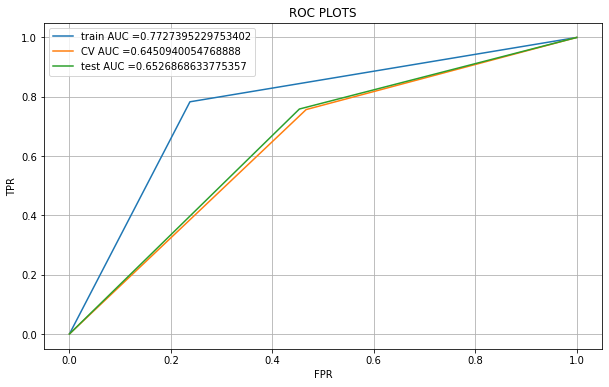

CPU times: user 179 ms, sys: 9 ms, total: 188 ms
Wall time: 188 ms


In [48]:
%%time
plt.figure(figsize=(10,6))
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_train_bow)
cv_fpr, cv_tpr, te_thresholds = roc_curve(y_cv, y_pred_cv_bow)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_test_bow)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

In [49]:
alpha=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10 ,100 ,1000]
train_bow_auc=[]
cv_bow_auc=[]
test_bow_auc=[]
for i in alpha:
    nb=MultinomialNB(alpha= i)
    nb.fit(X_train_bow, y_train)
    y_pred_cv_bow=nb.predict(X_cv_bow)
    y_pred_train_bow=nb.predict(X_train_bow)
    y_pred_test_bow=nb.predict(X_test_bow)    
    auc1_bow=accuracy_score(y_pred_train_bow,y_train,normalize=True)*float(100)
    auc2_bow=accuracy_score(y_pred_cv_bow,y_cv,normalize=True)*float(100)
    auc3_bow=accuracy_score(y_pred_test_bow,y_test,normalize=True)*float(100)
    train_bow_auc.append(auc1_bow)
    cv_bow_auc.append(auc2_bow)
    test_bow_auc.append(auc3_bow)
    print(auc1_bow)
    print(auc2_bow)
    print(auc3_bow)
    print("--"*10)


78.91119795175852
73.47826086956522
73.83066361556064
--------------------
78.88424740600996
73.48970251716247
73.81235697940504
--------------------
78.86740331491713
73.51258581235697
73.83066361556064
--------------------
78.73433499528365
73.39816933638444
73.7116704805492
--------------------
78.63495485783587
73.4096109839817
73.66590389016018
--------------------
78.24585635359117
72.98627002288329
73.35469107551488
--------------------
77.27395229753402
72.31121281464532
72.66819221967964
--------------------
74.5991106319903
71.1441647597254
71.71624713958809
--------------------
70.09163185554507
72.29977116704805
73.1350114416476
--------------------
61.295647486861604
80.75514874141876
81.4096109839817
--------------------


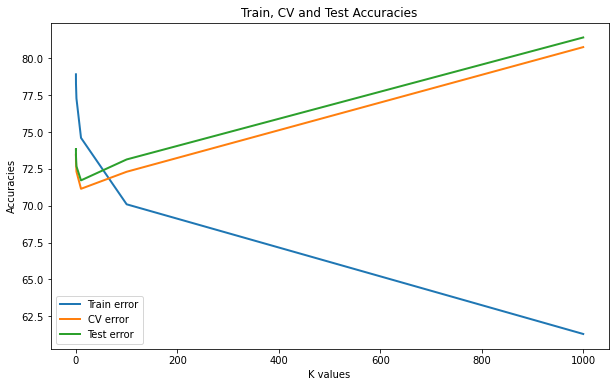

CPU times: user 168 ms, sys: 3.99 ms, total: 172 ms
Wall time: 172 ms


In [50]:
%%time
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
alpha=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10 ,100 ,1000]
plt.plot(alpha,train_bow_auc, label="Train error", linewidth=2)
plt.plot(alpha,cv_bow_auc, label="CV error", linewidth=2)
plt.plot(alpha,test_bow_auc, label="Test error", linewidth=2)

plt.title("Train, CV and Test Accuracies")
plt.xlabel("K values")
plt.ylabel("Accuracies")
plt.legend()
plt.show()

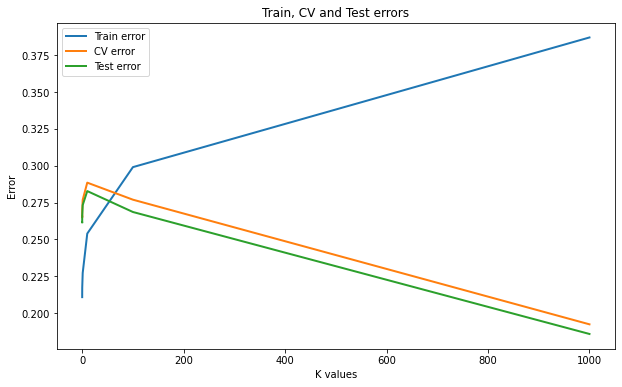

CPU times: user 166 ms, sys: 3 ms, total: 169 ms
Wall time: 169 ms


In [51]:
%%time
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

alpha=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10 ,100 ,1000]

train_bow_err=[1-(i/100) for (i) in train_bow_auc]
cv_bow_err=[1-(i/100) for (i) in cv_bow_auc]
test_bow_err=[1-(i/100) for (i) in test_bow_auc]

plt.plot(alpha,train_bow_err, label="Train error", linewidth=2)
plt.plot(alpha,cv_bow_err, label="CV error", linewidth=2)
plt.plot(alpha,test_bow_err, label="Test error", linewidth=2)

plt.title("Train, CV and Test errors")
plt.xlabel("K values")
plt.ylabel("Error")
plt.legend()
plt.show()

In [52]:
%%time
params= {'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10 ,100 ,1000]}
gs=GridSearchCV(estimator= MultinomialNB(), param_grid=params, cv=3, scoring='roc_auc')
gs.fit(X_train_bow, y_train)


CPU times: user 2.19 s, sys: 25.9 ms, total: 2.22 s
Wall time: 2.22 s


In [53]:
gs.best_estimator_

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

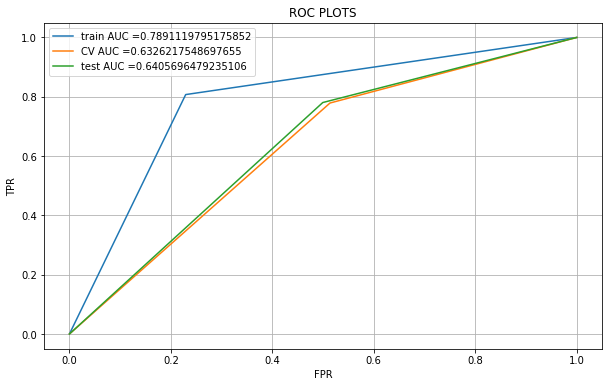

CPU times: user 438 ms, sys: 1.97 ms, total: 440 ms
Wall time: 442 ms


In [54]:
%%time

nb=MultinomialNB(alpha= 0.0001)
nb.fit(X_train_bow, y_train)
y_pred_cv_bow=nb.predict(X_cv_bow)
y_pred_train_bow=nb.predict(X_train_bow)
y_pred_test_bow=nb.predict(X_test_bow)

plt.figure(figsize=(10,6))
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_train_bow)
cv_fpr, cv_tpr, te_thresholds = roc_curve(y_cv, y_pred_cv_bow)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_test_bow)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


[[22881  6803]
 [ 5717 23967]]


Text(0.5, 1.0, 'BOW Train Confusion Matrix')

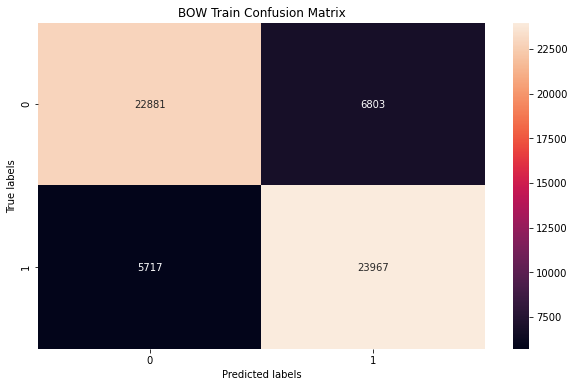

In [56]:
plt.figure(figsize=(10,6))
cm=confusion_matrix(y_train, y_pred_train_bow)
ax= plt.subplot()
sns.heatmap(cm,annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
print(cm)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('BOW Train Confusion Matrix')


[[ 641  677]
 [1641 5781]]


Text(0.5, 1.0, 'BOW Train Confusion Matrix')

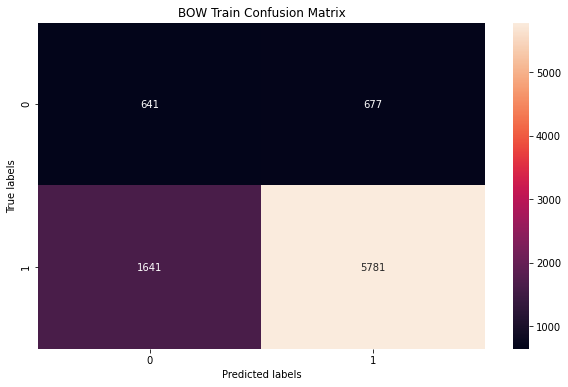

In [57]:
plt.figure(figsize=(10,6))
cm=confusion_matrix(y_cv, y_pred_cv_bow)
ax= plt.subplot()
sns.heatmap(cm,annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
print(cm)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('BOW Train Confusion Matrix')


[[ 825  823]
 [2036 7241]]


Text(0.5, 1.0, 'BOW Train Confusion Matrix')

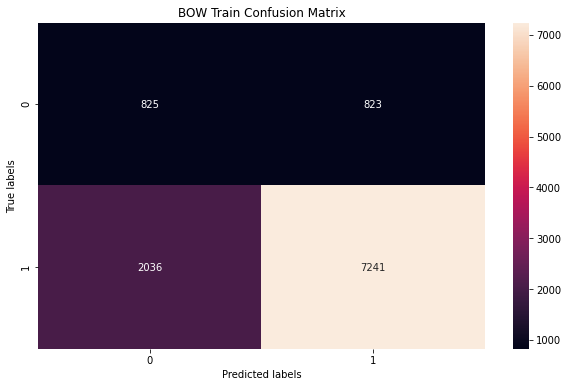

In [58]:
plt.figure(figsize=(10,6))
cm=confusion_matrix(y_test, y_pred_test_bow)
ax= plt.subplot()
sns.heatmap(cm,annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
print(cm)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('BOW Train Confusion Matrix')


In [59]:
alpha=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10 ,100 ,1000]
train_tf_auc=[]
cv_tf_auc=[]
test_tf_auc=[]
for i in alpha:
    nb=MultinomialNB(alpha= i)
    nb.fit(X_train_bow, y_train)
    y_pred_cv_tf=nb.predict(X_cv_tfidf)
    y_pred_train_tf=nb.predict(X_train_tfidf)
    y_pred_test_tf=nb.predict(X_test_tfidf)    
    auc1_tf=accuracy_score(y_pred_train_tf,y_train,normalize=True)*float(100)
    auc2_tf=accuracy_score(y_pred_cv_tf,y_cv,normalize=True)*float(100)
    auc3_tf=accuracy_score(y_pred_test_tf,y_test,normalize=True)*float(100)
    train_tf_auc.append(auc1_tf)
    cv_tf_auc.append(auc2_tf)
    test_tf_auc.append(auc3_tf)
    print(auc1_tf)
    print(auc2_tf)
    print(auc3_tf)
    print("--"*10)

77.36996361676324
63.00915331807781
63.07551487414188
--------------------
77.22847325158334
62.76887871853547
62.883295194508
--------------------
77.1560436598841
62.66590389016018
62.77345537757437
--------------------
76.94717693033284
62.42562929061785
62.57208237986271
--------------------
76.80905538337151
62.24256292906178
62.41647597254004
--------------------
76.23467187710551
61.7162471395881
61.90389016018306
--------------------
75.13475272874275
60.58352402745996
60.68649885583524
--------------------
72.38411265328124
57.76887871853547
58.08695652173913
--------------------
67.9423258320981
56.247139588100694
57.24485125858123
--------------------
62.1530117234874
66.18993135011442
67.69794050343249
--------------------


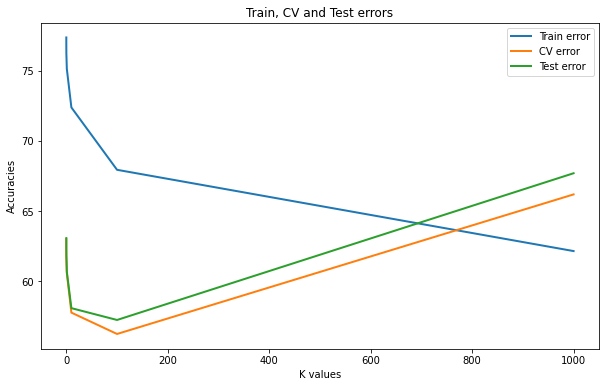

CPU times: user 149 ms, sys: 6 ms, total: 155 ms
Wall time: 155 ms


In [60]:
%%time
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
alpha=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10 ,100 ,1000]
plt.plot(alpha,train_tf_auc, label="Train error", linewidth=2)
plt.plot(alpha,cv_tf_auc, label="CV error", linewidth=2)
plt.plot(alpha,test_tf_auc, label="Test error", linewidth=2)

plt.title("Train, CV and Test errors")
plt.xlabel("K values")
plt.ylabel("Accuracies")
plt.legend()
plt.show()

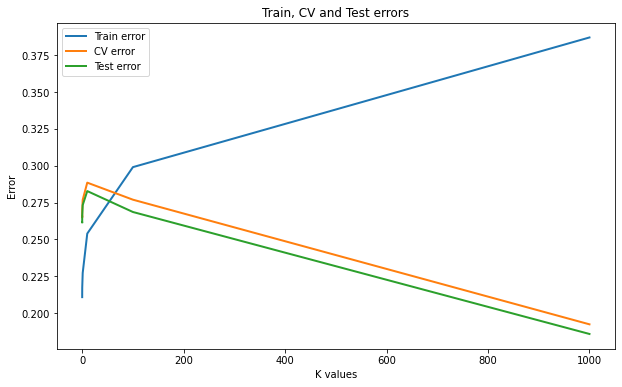

CPU times: user 175 ms, sys: 997 µs, total: 176 ms
Wall time: 178 ms


In [61]:
%%time
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

train_tf_err=[1-(i/100) for (i) in train_tf_auc]
cv_tf_err=[1-(i/100) for (i) in cv_tf_auc]
test_tf_err=[1-(i/100) for (i) in test_tf_auc]

plt.plot(alpha,train_bow_err, label="Train error", linewidth=2)
plt.plot(alpha,cv_bow_err, label="CV error", linewidth=2)
plt.plot(alpha,test_bow_err, label="Test error", linewidth=2)

plt.title("Train, CV and Test errors")
plt.xlabel("K values")
plt.ylabel("Error")
plt.legend()
plt.show()

In [62]:
gs.fit(X_train_tfidf, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1,
                                   10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [63]:
gs.best_estimator_

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)

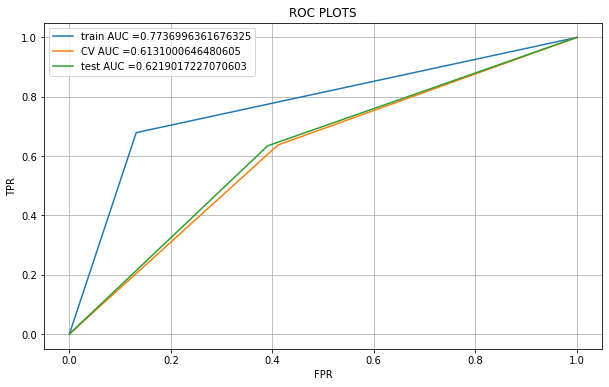

In [64]:
nb=MultinomialNB(alpha= 0.0001)
nb.fit(X_train_bow, y_train)
y_pred_cv_tfidf=nb.predict(X_cv_tfidf)
y_pred_train_tfidf=nb.predict(X_train_tfidf)
y_pred_test_tfidf=nb.predict(X_test_tfidf)

plt.figure(figsize=(10,6))
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_pred_train_tfidf)
cv_fpr, cv_tpr, te_thresholds = roc_curve(y_cv, y_pred_cv_tfidf)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_pred_test_tfidf)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOTS")
plt.grid()
plt.show()

[[25776  3908]
 [ 9527 20157]]


Text(0.5, 1.0, 'BOW Train Confusion Matrix')

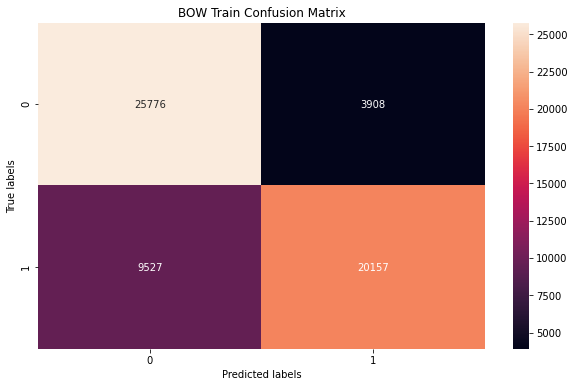

In [65]:
plt.figure(figsize=(10,6))
cm=confusion_matrix(y_train, y_pred_train_tfidf)
ax= plt.subplot()
sns.heatmap(cm,annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
print(cm)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('BOW Train Confusion Matrix')


[[ 776  542]
 [2691 4731]]


Text(0.5, 1.0, 'BOW Train Confusion Matrix')

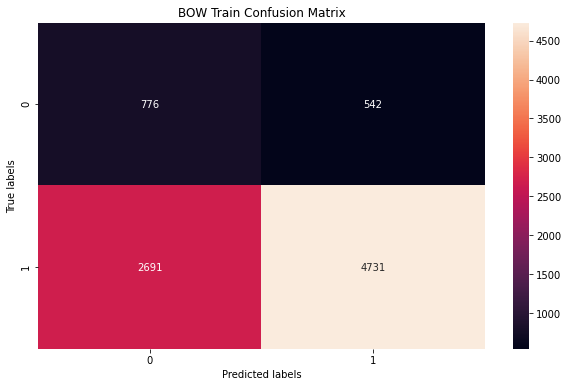

In [66]:
plt.figure(figsize=(10,6))
cm=confusion_matrix(y_cv, y_pred_cv_tfidf)
ax= plt.subplot()
sns.heatmap(cm,annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
print(cm)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('BOW Train Confusion Matrix')


[[1004  644]
 [3390 5887]]


Text(0.5, 1.0, 'BOW Train Confusion Matrix')

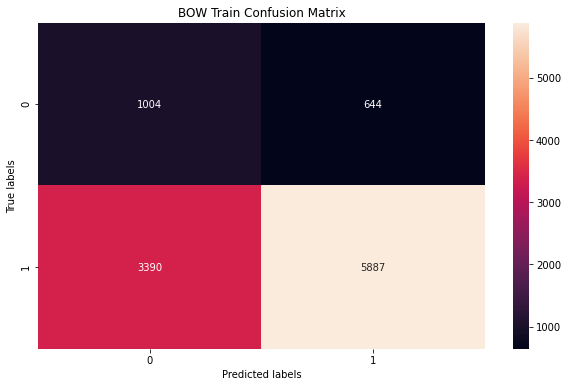

In [67]:
plt.figure(figsize=(10,6))
cm=confusion_matrix(y_test, y_pred_test_tfidf)
ax= plt.subplot()
sns.heatmap(cm,annot=True, ax = ax, fmt='d'); #annot=True to annotate cells
print(cm)
# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('BOW Train Confusion Matrix')
